# Biblioteki

In [26]:
import os
import pandas as pd 
import numpy as np
import sklearn
import joblib
import pickle
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer, plot_roc_curve, confusion_matrix, silhouette_score
import random
import matplotlib.pyplot as plt
from heart_class import features_extractor 
from joblib import dump
from sklearn.cluster import KMeans

In [6]:
print(sklearn.__version__)
print(joblib.__version__)
print(np.__version__)

1.0.1
1.0.1
1.20.1


# Wczytanie sygnałów pobranych z MIT-BIH (kaggle.com)

In [7]:
PATH="C:/Users/micha/Desktop/dadm projekt/archive/mitbih_database" 

os.chdir(PATH)
print(os.getcwd())
folder_files_list = os.listdir()
print(len(folder_files_list))

C:\Users\micha\Desktop\dadm projekt\archive\mitbih_database
96


In [8]:
csv_files = []
for file_name in folder_files_list:
    if(file_name.__contains__(".csv")):
        csv_files.append(file_name)
print(csv_files)

signals = []
for csv_file in csv_files:
    df = pd.read_csv(PATH+'/'+csv_file, delimiter=',')
    df_column = df.iloc[:,2]
    signals.append(df_column.to_numpy())

['100.csv', '101.csv', '102.csv', '103.csv', '104.csv', '105.csv', '106.csv', '107.csv', '108.csv', '109.csv', '111.csv', '112.csv', '113.csv', '114.csv', '115.csv', '116.csv', '117.csv', '118.csv', '119.csv', '121.csv', '122.csv', '123.csv', '124.csv', '200.csv', '201.csv', '202.csv', '203.csv', '205.csv', '207.csv', '208.csv', '209.csv', '210.csv', '212.csv', '213.csv', '214.csv', '215.csv', '217.csv', '219.csv', '220.csv', '221.csv', '222.csv', '223.csv', '228.csv', '230.csv', '231.csv', '232.csv', '233.csv', '234.csv']


In [9]:
txt_files = []
for file_name in folder_files_list:
    if(file_name.__contains__(".txt")):
        txt_files.append(file_name)
print(txt_files)

index_pairs = []
annotations = []
for txt_file in txt_files:
    df2 = pd.read_csv(PATH+'/'+txt_file, delimiter='\t', header=None)
    df2 = df2.drop(0)
    df2 = df2.iloc[:,0].str.split("\s+",expand = True)
    indexes = df2.iloc[:,2].to_numpy()
    annotations_signal = df2.iloc[:,3].to_numpy()
    indexes = np.insert(indexes,0,[0],axis=0)
    index_signal = []
    for i in range(len(indexes)-1):
        local_index = []
        local_index.append(int(indexes[i]))
        local_index.append(int(indexes[i+1]))
        index_signal.append(local_index)
    index_pairs.append(index_signal)
    for i in range(len(annotations_signal)):
        annotations.append(annotations_signal[i])

['100annotations.txt', '101annotations.txt', '102annotations.txt', '103annotations.txt', '104annotations.txt', '105annotations.txt', '106annotations.txt', '107annotations.txt', '108annotations.txt', '109annotations.txt', '111annotations.txt', '112annotations.txt', '113annotations.txt', '114annotations.txt', '115annotations.txt', '116annotations.txt', '117annotations.txt', '118annotations.txt', '119annotations.txt', '121annotations.txt', '122annotations.txt', '123annotations.txt', '124annotations.txt', '200annotations.txt', '201annotations.txt', '202annotations.txt', '203annotations.txt', '205annotations.txt', '207annotations.txt', '208annotations.txt', '209annotations.txt', '210annotations.txt', '212annotations.txt', '213annotations.txt', '214annotations.txt', '215annotations.txt', '217annotations.txt', '219annotations.txt', '220annotations.txt', '221annotations.txt', '222annotations.txt', '223annotations.txt', '228annotations.txt', '230annotations.txt', '231annotations.txt', '232annot

# Przygotowanie wstępnego zbioru sygnałów

In [10]:
### filtrowanie sygnałów z użyciem fragmentu kodu ecg_baseline
from scipy.signal import butter, filtfilt

sampling_freq = 360 # from MIT_BIH
order = 5
low_cutoff_freq = 5
high_cutoff_freq = 15

nyquist_freq = sampling_freq / 2
normalized_low = low_cutoff_freq / nyquist_freq
normalized_high = high_cutoff_freq / nyquist_freq
b, a = butter (order, [normalized_low, normalized_high], "bandpass", analog=False)

filtered_signals = [filtfilt(b, a, signal) for signal in signals]

In [11]:
### kontener fragmentów sygnalow
fragments = []
for i,signal in enumerate(filtered_signals):
    pairs = index_pairs[i] 
    for pair in pairs:
        a = pair
        signal_temp = signal[pair[0]:pair[1]]
        fragments.append(signal_temp)

### usuwanie pustych fragemntów i odpowiadających im adnotacji 
indexes_to_delete = []
for i, fragment in enumerate(fragments):
    if len(fragment) == 0:
        indexes_to_delete.append(i)
for index in indexes_to_delete:
    fragments.pop(index)
    annotations.pop(index)

# Przygotowanie danych na wejście

In [12]:
fe = features_extractor()
X = fe.get_features_vectors(fragments)

In [13]:
# Przykładowy wektore cech
print(X[0])

[42.38, 18.53, 9.0]


# Przygotowanie labeli

In [14]:
#Na postawie https://www.researchgate.net/publication/289188526_Classification_of_supraventricular_and_ventricular_beats_by_QRS_template_matching_and_decision_tree

all_classes = list(set(annotations))
SV = 'supraventricular'
subordinate_SV_labels = ['"','N','L','R','A','a','J','e','j']
V = 'ventricular'
subordinate_V_labels = ['S','V','F','[','!',']','E','f']
N = 'unclassifiable/artifact'
subordinate_N_labels = ['+', '~','|','Q','/','x']

reformed_annotations = []
for annotation in annotations:
    if(annotation in subordinate_SV_labels):
        reformed_annotations.append(SV)
    elif(annotation in subordinate_V_labels):
        reformed_annotations.append(V)
    else:
        reformed_annotations.append(N)

In [15]:
#Hot encoding
le = preprocessing.LabelEncoder()
le.fit(reformed_annotations)
labeled_ann = le.transform(reformed_annotations)
Y = labeled_ann.tolist() 

In [16]:
#zakowdowane labele
print(['supraventricular','unclassifiable/artifact','ventricular'])
print(set(Y))

['supraventricular', 'unclassifiable/artifact', 'ventricular']
{0, 1, 2}


# Znalezienie najlepszego modelu k-NN

In [17]:
# Podział i pomieszanie danych
to_shuffle = list(zip(X,Y))
random.shuffle(to_shuffle)
X,Y = zip(*to_shuffle)
X = list(X)
Y = list(Y)
split = int(len(X)*0.8)
X_train = X[:split]
X_test = X[split:]
Y_train = Y[:split]
Y_test = Y[split:]

Max accuracy:
0.8938748335552597
Dla liczby sąsiadów:
22


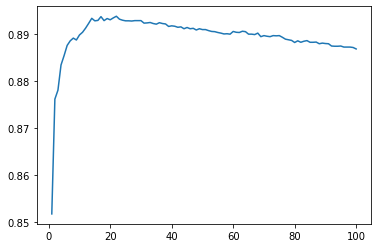

In [18]:
max_accuracy = 0
n = 0
pred = 0
accuracies = []
for i in range(1,101,1):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, Y_train)
    acc = model.score(X_test,Y_test)
    accuracies.append(acc)
    if (acc > max_accuracy):
        max_accuracy = acc
        n = i
   
print("Max accuracy:")
print(max_accuracy)
print("Dla liczby sąsiadów:")
print(n)
plt.figure(1)
plt.plot(list(range(1,101)), accuracies)
plt.show()

# Wyznacznie parametrów dla najlepszego modelu

In [22]:
cv = StratifiedKFold(5,shuffle=True,random_state=2)
model = KNeighborsClassifier(n_neighbors=22)

prec = []
recall = []
f1 = []
conf_matrix = []

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    conf_matrix.append(confusion_matrix(y_true, y_pred))
    vals = classification_report(y_true, y_pred,output_dict=True) # print classification report
    prec.append(vals['macro avg']['precision'])
    recall.append(vals['macro avg']['recall'])
    f1.append(vals['macro avg']['f1-score'])
    return accuracy_score(y_true, y_pred) # return accuracy score

score = cross_val_score(model, X=X, y=Y, cv=cv, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     18770
           1       0.74      0.61      0.67      1859
           2       0.64      0.35      0.46      1901

    accuracy                           0.89     22530
   macro avg       0.77      0.65      0.69     22530
weighted avg       0.88      0.89      0.88     22530

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18770
           1       0.73      0.63      0.68      1858
           2       0.65      0.35      0.45      1901

    accuracy                           0.89     22529
   macro avg       0.76      0.65      0.69     22529
weighted avg       0.88      0.89      0.88     22529

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     18769
           1       0.74      0.62      0.68      1858
           2       0.65      0.34      0.45      1902

    accuracy        

In [23]:
def calc(vals):
    m = np.mean(vals)
    s = np.std(vals)
    return str(round(m,2)) + " +/- " + str(round(s,2))

print("Ogólna skuteczność: " + calc(score) + " %")
print("Ogólna precyzja: " + calc(prec))
print("Ogólna czułość: " + calc(recall))
print("Ogólna miara f1 (2*(precyzja*czułość) / (precyzja+czułość)): " + calc(f1))

Ogólna skuteczność: 0.89 +/- 0.0 %
Ogólna precyzja: 0.76 +/- 0.0
Ogólna czułość: 0.65 +/- 0.0
Ogólna miara f1 (2*(precyzja*czułość) / (precyzja+czułość)): 0.69 +/- 0.0


In [24]:
print(sum(conf_matrix))

[[91203  1393  1251]
 [ 2975  5724   593]
 [ 5456   703  3348]]


In [28]:
model = KNeighborsClassifier(n_neighbors=22)
model.fit(X,Y)
model_name = 'k-NN.joblib'
model_path = "C:/Users/micha/Desktop/dadm projekt/" + model_name 
dump(model, model_path) 

['C:/Users/micha/Desktop/dadm projekt/k-NN.joblib']